In [54]:
import numpy as np
import pandas as pd
import sklearn
import nltk
# from nltk.stem.porter import PorterStemmer
nltk.download('punkt')
from sklearn import feature_extraction,model_selection
from sklearn.metrics import confusion_matrix
import glob
import os
import string
import tensorflow as tf
import keras as K
import zipfile
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
def load_csv(path):
  df=pd.read_csv(path).drop(['Sub-task B','ID'],axis=1)
  df=df[(df['Sub-task A']=="NAG")|(df['Sub-task A']=='CAG')|(df['Sub-task A']=='OAG')].dropna()
  df['Sub-task A'] = df['Sub-task A'].map({'NAG': 0, 'CAG': 1,'OAG': 2})
  return df

In [56]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
zip_ref = zipfile.ZipFile("/content/drive/My Drive/MinorProject/wiki.bn.zip", 'r')
zip_ref.extractall()
zip_ref.close()

In [111]:
train_df=load_csv("/content/drive/My Drive/MinorProject/iben_train.csv")
dev_df=load_csv("/content/drive/My Drive/MinorProject/iben_dev.csv")
print(train_df.head())
print(dev_df.head())

                                                Text  Sub-task A
0                                      Dada taratari           0
1                              Tumi korbe Amar sathe           0
2  Ar ta chara a sob bessha peter cheleder okhan ...           2
3                   কাকের শরীরে ময়ুরের পাখা লাগিয়েছে           1
4  পতিতাদের চরিত্র রাজনৈতিক নেতাদের থেকে হাজার গু...           0
                                                Text  Sub-task A
0  Ek dom sothik kotha bolecho jhekane theka uthe...           0
1                                        ফালতু মেয়ে           1
2                                   DARUN AKDOM THIK           0
3                                     Sala ranu magi           2
4                                থামবেল ঠিককোরে বানা           2


In [112]:
train_df.shape,dev_df.shape

((3826, 2), (957, 2))

In [113]:
Y_train=train_df['Sub-task A']
Y_train

0       0
1       0
2       2
3       1
4       0
       ..
3821    0
3822    1
3823    1
3824    0
3825    0
Name: Sub-task A, Length: 3826, dtype: int64

In [114]:
Y_dev=dev_df['Sub-task A']
Y_dev

0      0
1      1
2      0
3      2
4      2
      ..
952    1
953    0
954    0
955    0
956    0
Name: Sub-task A, Length: 957, dtype: int64

In [115]:
print(train_df['Sub-task A'].value_counts())
print(dev_df['Sub-task A'].value_counts())

0    2078
1     898
2     850
Name: Sub-task A, dtype: int64
0    522
1    218
2    217
Name: Sub-task A, dtype: int64


In [0]:
# importing Word2Vec
from gensim.models import Word2Vec
from gensim.models import FastText

In [117]:
#load pre-trained embedding:
embeddings_index = {}
f = open('/content/wiki.bn.vec', encoding="utf8")
for line in f:
    values = line.split()#This splits each values in a  line with spaces
    word = values[0] # This store the first values which is the word in english
    coefs = np.asarray(values[1:]) # This converts all splitted values from 1 to last(expect first word) into an array
    embeddings_index[word] = coefs # english word = array of numerical values
f.close()
print('Total %s word vectors in wiki.bin.vec.' % len(embeddings_index))

Total 145279 word vectors in wiki.bin.vec.


In [118]:
embeddings_index['the'].shape

(300,)

In [0]:
tk=Tokenizer()
tk.fit_on_texts(train_df['Text'])
word_index=tk.word_index
#print(index)
train_df = tk.texts_to_sequences(train_df['Text'])
dev_df=tk.texts_to_sequences(dev_df['Text'])

In [120]:
embedding_vecor_length =100
train_df = pad_sequences(train_df, maxlen=embedding_vecor_length, padding='post')
print (train_df)

[[    3  1240     0 ...     0     0     0]
 [   47   607    72 ...     0     0     0]
 [   32     4   492 ...     0     0     0]
 ...
 [  143   564   414 ...     0     0     0]
 [10558    42     0 ...     0     0     0]
 [ 3465 10559    48 ...     0     0     0]]


In [121]:
embedding_vecor_length =100
dev_df = pad_sequences(dev_df, maxlen=embedding_vecor_length, padding='post')
print (dev_df)

[[ 296  311 1853 ...    0    0    0]
 [ 306  857    0 ...    0    0    0]
 [  35   51    7 ...    0    0    0]
 ...
 [  14  644    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]
 [   3   77   54 ...    0    0    0]]


In [0]:
 # Initialize the weight for each word for the embedding layer. Words not present
# in the dictionary initialized by random value 
EMBEDDING_DIM = 300
embedding_matrix = np.random.random((len(word_index), EMBEDDING_DIM))
#embedding_matrix = (16433, 100) NOTE: It is from uniques words in our tweets
for word, i in word_index.items(): # Selecting word from our tweet unique words list for changing with the values from glove
    embedding_vector = embeddings_index.get(word+'1') # Finding our tweet words in glove and taking its array of 100 values
    if embedding_vector is not None: 
#words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [123]:
from keras.utils.np_utils import to_categorical
y_train = to_categorical(np.asarray(Y_train))
y_test = to_categorical(np.asarray(Y_dev))
# y_train=np.array(train_df['Sub-task A'])
# y_dev=np.array(dev_df['Sub-task A'])
print(y_train.shape, y_test.shape)

(3826, 3) (957, 3)


In [124]:
vocab_size=len(word_index)
vocab_size

10562

In [125]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D
from keras.utils.vis_utils import plot_model
model = Sequential()
model.add(Embedding(vocab_size, 8, input_length=100))
model.add(Conv1D(filters = 128,kernel_size=3, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation = 'softmax'))
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 8)            84496     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 98, 128)           3200      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 19, 128)           0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 19, 128)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2432)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               622848    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)              

In [126]:
history=model.fit(train_df, y_train, validation_data = (dev_df, y_test),epochs=100,batch_size=100, verbose=2)

Train on 3826 samples, validate on 957 samples
Epoch 1/100
 - 1s - loss: 1.0107 - acc: 0.5376 - val_loss: 0.9845 - val_acc: 0.5559
Epoch 2/100
 - 0s - loss: 0.9605 - acc: 0.5572 - val_loss: 0.9652 - val_acc: 0.5580
Epoch 3/100
 - 0s - loss: 0.8675 - acc: 0.5988 - val_loss: 0.8580 - val_acc: 0.5778
Epoch 4/100
 - 0s - loss: 0.6432 - acc: 0.7133 - val_loss: 0.8457 - val_acc: 0.6499
Epoch 5/100
 - 0s - loss: 0.4111 - acc: 0.8539 - val_loss: 0.9433 - val_acc: 0.6364
Epoch 6/100
 - 0s - loss: 0.2619 - acc: 0.9182 - val_loss: 1.0350 - val_acc: 0.6196
Epoch 7/100
 - 0s - loss: 0.1656 - acc: 0.9569 - val_loss: 1.1751 - val_acc: 0.6353
Epoch 8/100
 - 0s - loss: 0.1148 - acc: 0.9699 - val_loss: 1.3166 - val_acc: 0.6353
Epoch 9/100
 - 0s - loss: 0.0836 - acc: 0.9786 - val_loss: 1.4306 - val_acc: 0.6385
Epoch 10/100
 - 0s - loss: 0.0667 - acc: 0.9846 - val_loss: 1.5143 - val_acc: 0.6207
Epoch 11/100
 - 0s - loss: 0.0572 - acc: 0.9872 - val_loss: 1.5967 - val_acc: 0.6343
Epoch 12/100
 - 0s - loss: 

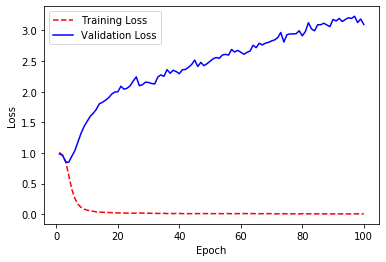

In [127]:
training_loss=history.history['loss']
validation_loss=history.history['val_loss']
epoch_count=range(1,len(training_loss)+1)
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, validation_loss, 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [128]:
scores = model.evaluate(dev_df, y_test, verbose=0)
print(scores)

[3.09675639699619, 0.646812956410391]


In [129]:
predictions_test = model.predict(dev_df)
print(predictions_test)

[[1.0000000e+00 5.8216367e-15 9.4886068e-22]
 [4.1171224e-03 8.0390088e-04 9.9507892e-01]
 [9.9995911e-01 3.9704220e-05 1.1546231e-06]
 ...
 [9.9995744e-01 4.2544365e-05 1.6309553e-22]
 [5.5560601e-01 2.1029679e-01 2.3409724e-01]
 [9.9999988e-01 3.1283025e-09 1.2481001e-07]]


In [0]:
predictions_test1 = np.zeros_like(predictions_test)
predictions_test1[np.arange(len(predictions_test)), predictions_test.argmax(1)] = 1

In [131]:
from sklearn.metrics import classification_report
print(classification_report(y_test,predictions_test1))

              precision    recall  f1-score   support

           0       0.75      0.80      0.77       522
           1       0.45      0.36      0.40       218
           2       0.55      0.58      0.56       217

   micro avg       0.65      0.65      0.65       957
   macro avg       0.58      0.58      0.58       957
weighted avg       0.64      0.65      0.64       957
 samples avg       0.65      0.65      0.65       957

